In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from IPython.display import display, Math
from scipy.optimize import minimize
import astropy.units as u
from astropy.modeling.models import custom_model
from scipy import interpolate
import keras
from scipy.optimize import Bounds
import sys
sys.path.insert(0, '/media/carterrhea/carterrhea/SIGNALS/LUCI/')  # Location of Luci
import LUCI.LuciFit as lfit
import emcee
import corner


In [2]:
# Read in Data

sigma_info = []
velocity_info = []
res_info = []
spectrum = fits.open('../Data/Reference-Spectrum-R5000.fits')
header = spectrum[0].header
spec = spectrum[1].data
channel = []
counts = []
for chan in spec:
    channel.append(chan[0])
    counts.append(chan[1])

axis = channel
sky = counts
velocity = header['VELOCITY']
sigma = header['BROADEN']
print(velocity, sigma)

0 10


In [3]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('../ML/Reference-Spectrum-R5000.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]

In [4]:
f = interpolate.interp1d(axis, sky, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale
print(sky_corr.shape)

(460,)


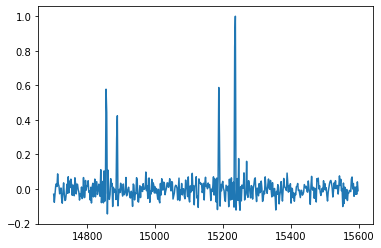

In [5]:
plt.plot(wavenumbers_syn, sky_corr)

In [6]:
fit = lfit.Fit(sky, axis, wavenumbers_syn, 'sincgauss', ['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], [1,1,1,1,1], [1,1,1,1,1],
                keras.models.load_model('../ML/R5000-PREDICTOR-I'),
                 bayes_bool=False)
fit_dict = fit.fit()
print(fit_dict['broadening'])
print(fit_dict['fit_sol'])

8.230438173525293
[1.00097477e+00 1.52365805e+04 9.84344084e-01 5.88502223e-01
 1.51888809e+04 9.81262500e-01 1.61248768e-01 1.52709487e+04
 9.86564410e-01 4.24875671e-01 1.48879739e+04 9.61822707e-01
 5.78698988e-01 1.48561668e+04 9.59767839e-01 0.00000000e+00]


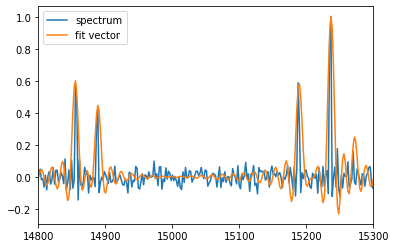

In [7]:
plt.plot(axis, sky, label='spectrum')
plt.plot(axis, fit_dict['fit_vector'], label='fit vector')
plt.xlim(14800, 15300)
plt.legend()

In [8]:
fit_dict['amplitudes']

[1.000974769180175,
 0.5885022230795585,
 0.1612487681559287,
 0.42487567145144567,
 0.5786989875487052]